In [1]:
!nvidia-smi

Wed Nov 23 04:35:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

import os
import pathlib
import shutil
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [3]:
"""
lfw/
    csv files
    lfw-deepfunneled/
data/
    train/
    val/
    test/
notebook
"""


'\nlfw/\n    csv files\n    lfw-deepfunneled/\ndata/\n    train/\n    val/\n    test/\nnotebook\n'

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)
os.getcwd()
os.listdir("../")

cuda


['src', 'lib', 'input', 'working']

In [5]:
data_folder = '../input/lfw-dataset/'

In [6]:
lfw_allnames = pd.read_csv(data_folder+"lfw_allnames.csv")

image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: str(x).zfill(4))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)

In [7]:
num_people = 25
print(image_paths['name'].value_counts()[:num_people])
list_people = list(image_paths['name'].value_counts()[:num_people].keys())
list_num_images = list(image_paths['name'].value_counts()[:num_people])
print(list_people, list_num_images)

George_W_Bush                530
Colin_Powell                 236
Tony_Blair                   144
Donald_Rumsfeld              121
Gerhard_Schroeder            109
Ariel_Sharon                  77
Hugo_Chavez                   71
Junichiro_Koizumi             60
Jean_Chretien                 55
John_Ashcroft                 53
Jacques_Chirac                52
Serena_Williams               52
Vladimir_Putin                49
Luiz_Inacio_Lula_da_Silva     48
Gloria_Macapagal_Arroyo       44
Jennifer_Capriati             42
Arnold_Schwarzenegger         42
Laura_Bush                    41
Lleyton_Hewitt                41
Hans_Blix                     39
Alejandro_Toledo              39
Nestor_Kirchner               37
Andre_Agassi                  36
Alvaro_Uribe                  35
Silvio_Berlusconi             33
Name: name, dtype: int64
['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chre

In [8]:

num_for_each = 30
tmp_l = []
for name in list(image_paths['name'].value_counts()[:num_people].keys()):
    tmp_l.append(image_paths[image_paths.name==name].sample(num_for_each))
data = pd.concat(tmp_l)
print(data)

                   name                                    image_path
1871      George_W_Bush          George_W_Bush/George_W_Bush_0173.jpg
1871      George_W_Bush          George_W_Bush/George_W_Bush_0310.jpg
1871      George_W_Bush          George_W_Bush/George_W_Bush_0401.jpg
1871      George_W_Bush          George_W_Bush/George_W_Bush_0375.jpg
1871      George_W_Bush          George_W_Bush/George_W_Bush_0108.jpg
...                 ...                                           ...
5039  Silvio_Berlusconi  Silvio_Berlusconi/Silvio_Berlusconi_0022.jpg
5039  Silvio_Berlusconi  Silvio_Berlusconi/Silvio_Berlusconi_0016.jpg
5039  Silvio_Berlusconi  Silvio_Berlusconi/Silvio_Berlusconi_0014.jpg
5039  Silvio_Berlusconi  Silvio_Berlusconi/Silvio_Berlusconi_0027.jpg
5039  Silvio_Berlusconi  Silvio_Berlusconi/Silvio_Berlusconi_0028.jpg

[750 rows x 2 columns]


In [9]:
data_train, data_test = train_test_split(data, test_size=0.2)
data_train, data_val = train_test_split(data_train, test_size=0.2)

In [10]:
print(data_train.shape, data_val.shape, data_test.shape)

(480, 2) (120, 2) (150, 2)


In [11]:
data_root = './data/'

data_list = [data_train, data_val, data_test]
dirs = ['train', 'val', 'test']

             # uncomment this line and run, to copy
                #first remove data directory if it exists
for i in range(len(dirs)):
    pathlib.Path(os.path.join(data_root, dirs[i])).mkdir(parents=True, exist_ok=True)
    
    for person in list_people:
        if len(data_train[data_train['name']==person])>0:
            pathlib.Path(os.path.join(data_root, dirs[i], person)).mkdir(parents=True, exist_ok=True)

    for im_path in data_list[i].image_path:
        name = data[data['image_path']==im_path]['name'].iloc[0]
        path_from = os.path.join(data_folder+'/lfw-deepfunneled/lfw-deepfunneled/', im_path)
        path_to = os.path.join(data_root, dirs[i], name)
        if not os.path.isfile(os.path.join(path_to, im_path)):
            shutil.copy(path_from, path_to)


In [12]:
train_path = os.path.join(data_root, dirs[0])
val_path = os.path.join(data_root, dirs[1])
test_path = os.path.join(data_root, dirs[2])

train_transform = transforms.Compose(transforms=[
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=0, std=255),      # output = (input-mean)/std
])
test_transform = transforms.Compose(transforms=[
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=0, std=255)
])

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, train_transform), shuffle=True  ,batch_size = 10
)
val_loader = DataLoader(
    torchvision.datasets.ImageFolder(val_path, test_transform), shuffle=True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, test_transform), shuffle=True
)

In [13]:
for data in train_loader:
    print(data[0].shape, data[1].shape)
    break
# Total train data is of shape (128, 3, 250, 250)

torch.Size([10, 3, 224, 224]) torch.Size([10])


In [14]:
class FaceCNN(nn.Module):
    def __init__(self, num_classes, stride=1, padding=1):
        super().__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=stride, padding=padding),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=stride, padding=padding),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
            
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=stride, padding=padding),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
            
        nn.Flatten(),
        nn.Linear(in_features=25088, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=1000),
        nn.ReLU(),
        nn.Linear(in_features=1000, out_features=num_classes),
        nn.Softmax(dim = 1)
        )
        

    def forward(self, input):
        output = self.cnn_model(input)

        return output

In [15]:
model = FaceCNN(num_classes=len(list_people))
""""
model =torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
    
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 1000), 
    nn.ReLU(),
    nn.Linear(1000, 200), 
    nn.ReLU(),
    nn.Linear(200, len(list_people)), 
    nn.Softmax(dim=1))
"""
model = model.to(device)
#model.classifier


In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 500

In [17]:
def evaluate(loader, model):
    model.eval()

    score = 0
    cnt = 0

    with torch.no_grad():       # not training, so no need to calculate gradients
        for data in loader:
            for i in range(len(data)):
                data[i] = data[i].to(device)
            # images, labels = data
            output = model(data[0])
            _, pred = torch.max(output.data, 1)
            score += float(torch.sum(pred==data[1].data))
            cnt += data[0].shape[0]

    return score/cnt

In [18]:

train_accuracy = []
val_accuracy = []
def train():
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        train_score = 0
        cnt = 0
        train_loss = 0

        model.train()
        
        for batch in train_loader:
            for i in range(len(batch)):
                batch[i] = batch[i].to(device)
            optimizer.zero_grad()
            output = model(batch[0])
            label = batch[1]
            
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            _, pred = torch.max(output.data, 1)
            train_score += float(torch.sum(pred==label.data))
            cnt += batch[0].shape[0]

        train_acc = train_score/cnt
        val_acc = evaluate(val_loader, model)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)
        
        print("Epoch:", epoch, "\tLoss:", train_loss, "\tTraining Acc:", train_acc, "\tVal Acc:", val_acc)

        if val_acc > best_acc:
            torch.save(model.state_dict(),'best.model')
            best_acc = val_acc

In [19]:
train()

Epoch: 0 	Loss: 154.50610065460205 	Training Acc: 0.025 	Val Acc: 0.016666666666666666
Epoch: 1 	Loss: 154.50380086898804 	Training Acc: 0.04375 	Val Acc: 0.025
Epoch: 2 	Loss: 154.50337958335876 	Training Acc: 0.027083333333333334 	Val Acc: 0.041666666666666664
Epoch: 3 	Loss: 154.50204420089722 	Training Acc: 0.04375 	Val Acc: 0.041666666666666664
Epoch: 4 	Loss: 154.50192523002625 	Training Acc: 0.04375 	Val Acc: 0.03333333333333333
Epoch: 5 	Loss: 154.50068140029907 	Training Acc: 0.05625 	Val Acc: 0.03333333333333333
Epoch: 6 	Loss: 154.49947118759155 	Training Acc: 0.05 	Val Acc: 0.03333333333333333
Epoch: 7 	Loss: 154.49922442436218 	Training Acc: 0.05625 	Val Acc: 0.03333333333333333
Epoch: 8 	Loss: 154.49884343147278 	Training Acc: 0.041666666666666664 	Val Acc: 0.041666666666666664
Epoch: 9 	Loss: 154.49754810333252 	Training Acc: 0.05 	Val Acc: 0.041666666666666664
Epoch: 10 	Loss: 154.4960594177246 	Training Acc: 0.035416666666666666 	Val Acc: 0.05
Epoch: 11 	Loss: 154.4935

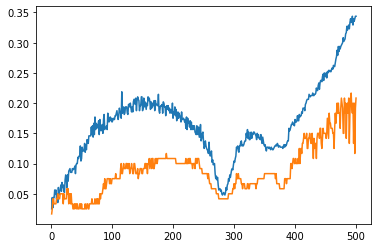

In [20]:
epoch = []
for i in range(num_epochs):
    epoch.append(i+1)
plt.plot(epoch,train_accuracy)
plt.plot(epoch,val_accuracy)
plt.savefig("VGG16-SGD-Batchnorm.png")

In [21]:
with open("train.txt",'w',encoding = 'utf-8') as f:
   for i in train_accuracy:
    f.write(str(i)+"\n")
    
with open("val.txt",'w',encoding = 'utf-8') as f:
   for i in val_accuracy:
    f.write(str(i)+"\n")
print(num_epochs)

500


In [22]:
best_model = torch.load('best.model')
best_model  = best_model.to(device)
score = 0
cnt = 0

with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        output = best_model(data[0])
        _, pred = torch.max(output.data, 1)
        score += float(torch.sum(pred==data[1].data))
        cnt += data[0].shape[0]

print(score/cnt)

AttributeError: 'collections.OrderedDict' object has no attribute 'to'